# Homework 6, Problem 4 - Particle filter
You will change the observation model (cell 6) and the observation probability (cell 10) to make
this particle filter simulation have Poisson observations instead of Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
np.random.seed(0)

In [3]:
# 1-D state dynamics
def state_dynamics(z):
    return z + np.random.randn(*z.shape)

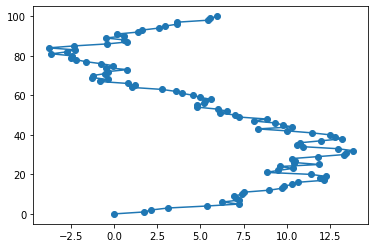

In [4]:
# Generate a random simulation of our latent state dynamics
z = [np.array(0)]
t = [0]
for i in range(100):
    z.append(state_dynamics(z[-1]))
    t.append(i+1)

plt.plot(z,t,'-o')

In [5]:
## For our observations, we will define Place Fields with Gaussian-like receptive fields 
NumberOfNeurons = 20
PF_Centers = np.random.rand(NumberOfNeurons) * 100 # Place fields center between 0 and 100
PF_Max = 10 # Maximum firing rate
PF_Width = 25 # Width or fall off in space of Place fields

def mean_rate(z):
    return np.exp(-((z - PF_Centers)/PF_Width)**2) * PF_Max

In the following cell, we changed the observation to be Poisson.

In [6]:
###
### For homework you will change this to Poisson!
###

## For Gaussian model, we need a standard deviation per neuron
Gaussian_PF_Noise_Variance = 10
def observation_gaussian(z):
    # Additive Gaussian noise. Change this to Poisson!
    return mean_rate(z) + np.random.randn(len(PF_Centers))*np.sqrt(Gaussian_PF_Noise_Variance)


# Randomly generate an observation from neurons
def observation_poisson(z):
    # Additive Poisson noise.
    return np.random.poisson(lam=mean_rate(z)) # lambda is the mean_rate of z

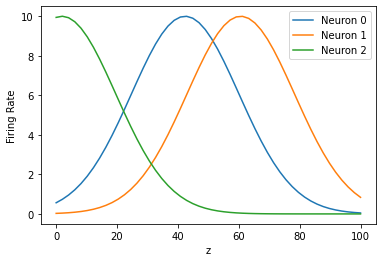

In [7]:
# Plot some example receptive fields
z = np.linspace(0,100)
nn = np.array([mean_rate(z_) for z_ in z])
plt.plot(z,nn[:,0], label='Neuron 0')
plt.plot(z,nn[:,1], label='Neuron 1')
plt.plot(z,nn[:,2], label='Neuron 2')
plt.gca().set_ylabel('Firing Rate')
plt.gca().set_xlabel('z')
plt.legend()
plt.show()

In [8]:
# Here's the trajectory we will try to decode
Trajectory = np.linspace(0,100,num=101)

In [9]:
# Here's the neural activity corresponding to our trajectory

Neural_Activity_gaussian = np.array([observation_gaussian(z) for z in Trajectory])
Neural_Activity_poisson = np.array([observation_poisson(z) for z in Trajectory])

In the following cell, we also chenged the ``p_observation`` to be Poisson.

In [10]:

###
### Homework - Modify this to be Poisson!
### 
    
def p_observation_gaussian(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Gaussian
    return np.exp(scipy.stats.norm.logpdf(x, mean_rate(z), np.sqrt(Gaussian_PF_Noise_Variance)).sum())

def p_observation_poisson(x, z):
    # Quick way of calculating Multivariate normal with uncorrelated dimensions
    # Calculate the product across neurons as exp( sum (log_probabilities) )
    
    # Poisson
    return np.exp(scipy.stats.poisson.logpmf(x, mean_rate(z)).sum())

In [11]:
# Run the particle filter
def particle_filter(p_observation, Neural_Activity):
    N = 100
    Z = []
    I = []
    Z_ = []
    W = []


    # Start by sampling initial distribution, N(0,10)
    # Generate N particles corresponding to time 0
    Z.append(np.random.randn(N)*np.sqrt(10))

    ### In python Z[-1] refers to the last item in a list or vector

    for i in range(101):
        # Calculate a posteriori probability for each particle
        APosterioriProb = np.array([p_observation(Neural_Activity[i,:],z) for z in Z[-1]])
        # Normalize probabilities to get a weight vector
        W.append(APosterioriProb / APosterioriProb.sum())
        # Sample particles using weights - I[] keeps track of the indices chosen
        #  we could do it more efficiently like this:
        #      z_ =  np.random.choice(Z[-1],size=N,replace=True,p=W[-1])
        idx =  np.random.choice(N,size=N,replace=True,p=W[-1])
        I.append(idx)
        z_ = Z[-1][idx]
        Z_.append(z_)
        # Step forward in time by sampling from the dynamics
        Z.append( state_dynamics(z_) )
        
    # For plotting the distribution of particles at a particular time step
    t = 50
    pp = np.array([p_observation(Neural_Activity[t,:],z) for z in Z[t]])
    pp = pp / pp.sum()

    return pp, z, Z, Z_, t, W, N

In [12]:
pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

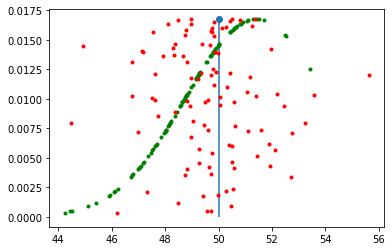

In [13]:
plt.plot(Z[t], pp,'g.')
plt.plot(Z[t+1], pp,'r.')
plt.stem([Trajectory[t]], [np.max(W[t])])
plt.show()

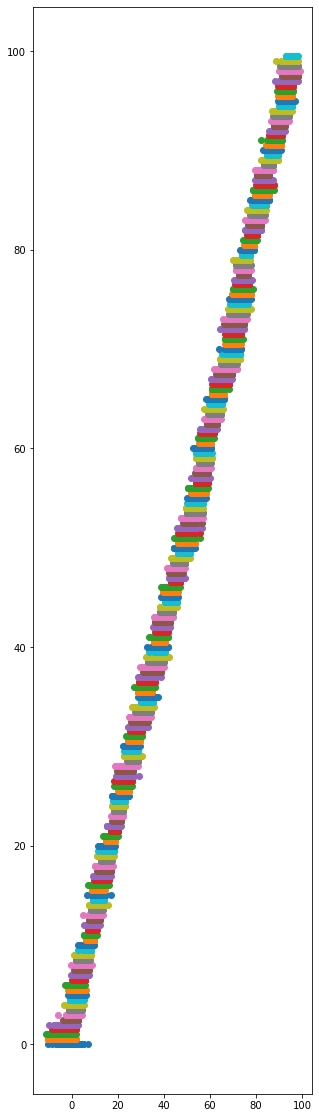

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,20))
for i in range(100):
    ax.plot(Z[i], i*np.ones(N), 'o')
    ax.plot(Z_[i], i*np.ones(N)+0.5, 'o')

MSE = 4.675923551186773


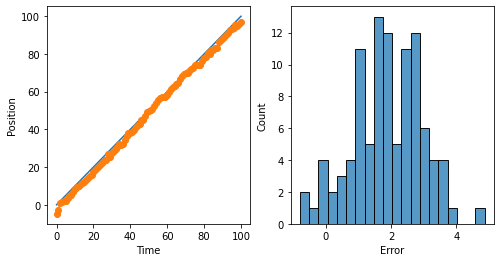

In [15]:
# Calculate estimated trajectory

Z_ = np.array(Z)
W_ = np.array(W)

EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


# Plot estimated trajectory and error histogram
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(Trajectory)
axs[0].plot(EstimatedTrajectory, '-o')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')

Error = (Trajectory - EstimatedTrajectory)

sns.histplot(Error, ax=axs[1], bins=20, kde=False)
axs[1].set_xlabel('Error')
print('MSE = {}'.format(np.mean(Error**2)))

#### Commentary - notice that the error is strongly biased. This is because the animal is moving further 
####   each timestep than would be likely for a N(0,1) random walk. Try changing the "speed" of the animal
####   to 0.5 or 0.1 cm per time step and see if the error is still biased.


We want to generate a cycle that runs, say 10 times for Poisson and 10 times for Gaussian so we can compare MSE values

MSE = 4.434706786845836
MSE = 3.598350001336474
MSE = 4.209126142068755
MSE = 4.532533915094544
MSE = 4.22058449926637
MSE = 3.7495315008050976
MSE = 4.180653648504263
MSE = 4.15747585183777
MSE = 4.031033160134049
MSE = 4.3533403504125685


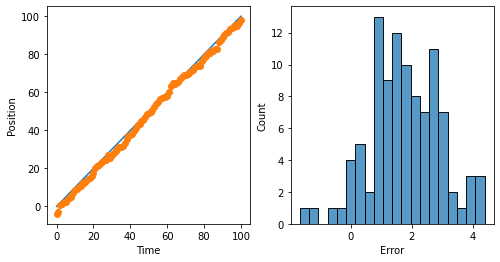

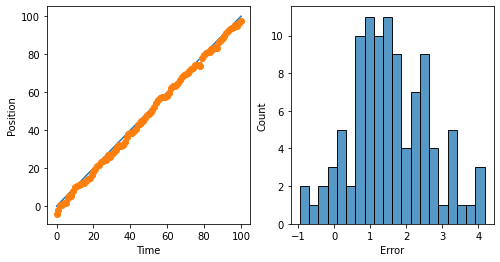

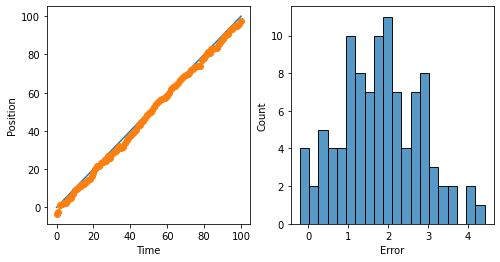

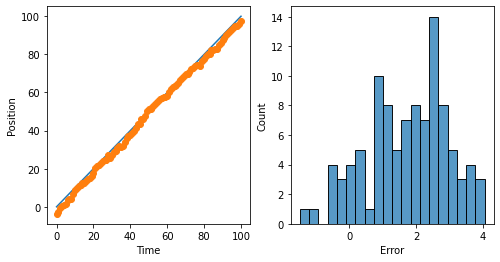

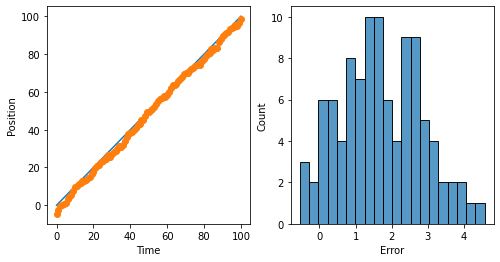

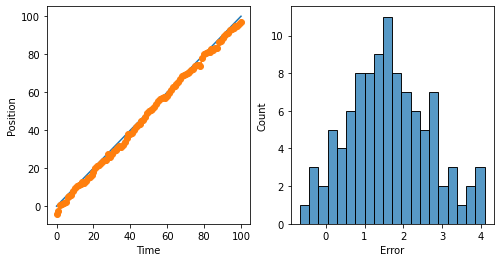

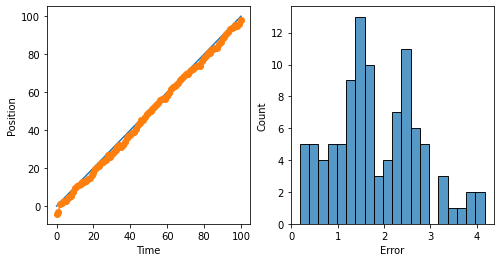

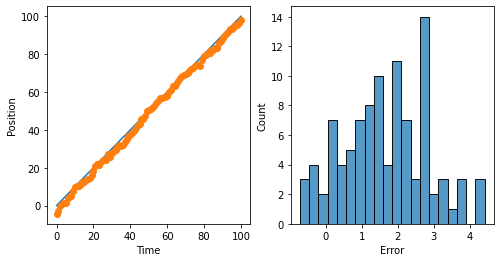

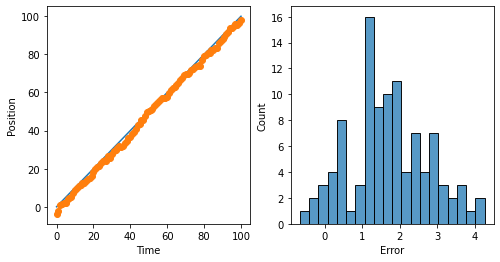

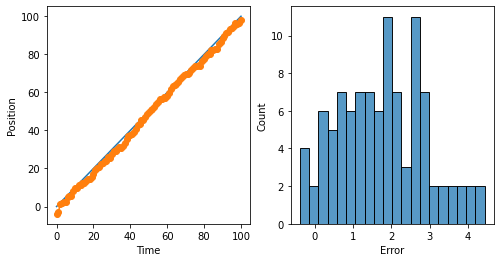

In [16]:
# Poisson cycle
iterations = 10
MSE_poisson = np.zeros(iterations)
# MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_poisson, Neural_Activity_poisson)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_poisson[i] = np.mean(Error**2)

MSE = 17.710804718143887
MSE = 15.094691975848216
MSE = 16.504857436135502
MSE = 19.653055836373145
MSE = 13.963588436396954
MSE = 15.146542478105292
MSE = 16.336788124251918
MSE = 16.925758369011408
MSE = 15.727253040778445
MSE = 17.31071443860848


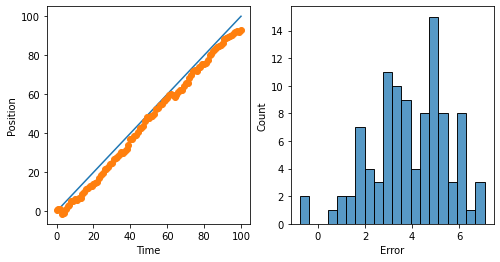

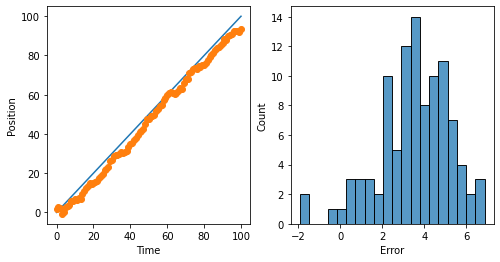

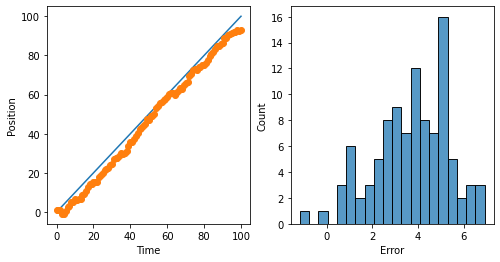

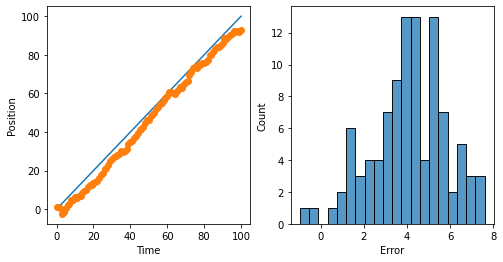

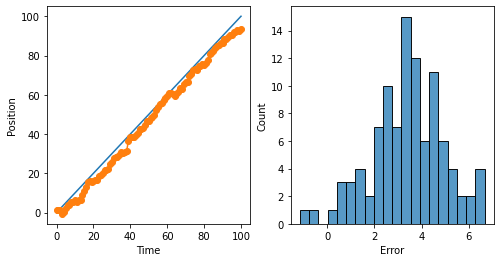

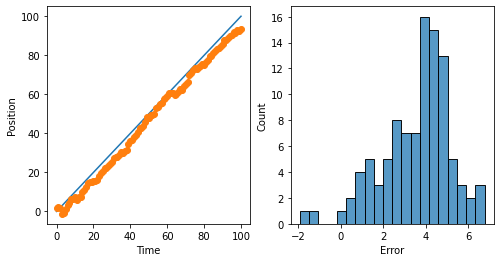

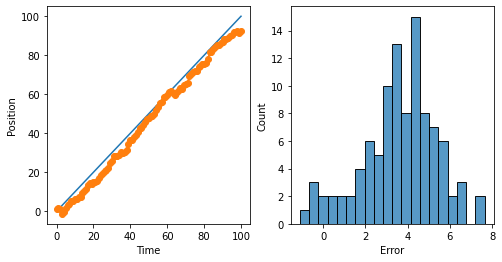

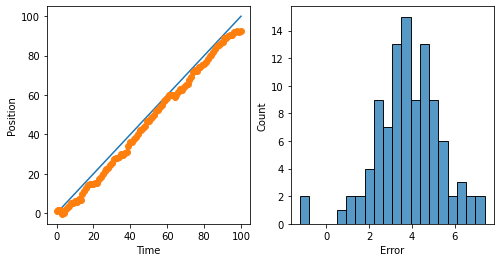

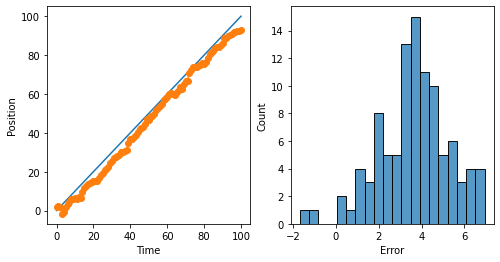

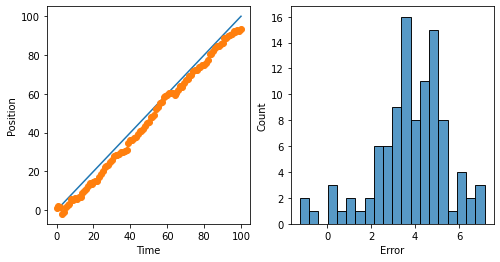

In [17]:
# Gaussian cycle
iterations = 10
MSE_gaussian = np.zeros(iterations)

for i in range(iterations):
    pp, z, Z, Z_, t, W, N = particle_filter(p_observation_gaussian, Neural_Activity_gaussian)

    # Calculate estimated trajectory

    Z_ = np.array(Z)
    W_ = np.array(W)

    EstimatedTrajectory = np.sum(Z_[:-1] * W_[:], axis=1)


    # Plot estimated trajectory and error histogram
    fig, axs = plt.subplots(1, 2, figsize=(8,4))

    axs[0].plot(Trajectory)
    axs[0].plot(EstimatedTrajectory, '-o')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Position')

    Error = (Trajectory - EstimatedTrajectory)

    sns.histplot(Error, ax=axs[1], bins=20, kde=False)
    axs[1].set_xlabel('Error')
    print('MSE = {}'.format(np.mean(Error**2)))
    MSE_gaussian[i] = np.mean(Error**2)

In [18]:
print("Mean gaussian: ",np.mean(MSE_gaussian))
print("Mean poisson: ",np.mean(MSE_poisson))

Mean gaussian:  16.437405485365325
Mean poisson:  4.146733585630573


Notice how the mean standard error in the gaussian observations are higher compared to the poisson ones.

# FALTA! Is this what you expected? How could you change the Gaussian model to reduce its MSE?

#### b. Experiment with the number of neurons and the maximum firing rates. How does the error change if the number of neurons decreases or increases by a factor of 2? How does the error change if the maximum firing rate decreases or increases by a factor of 2?

c. Experiment with the number of particles. How does the error change if the number of particles used for simulation changes by a factor of 10 (i.e., 10, 100, or 1000)?

d. Experiment with the state dynamics model. What happens to the error if the standard deviation of the “innovation” (the noise term added to the state at each time step) increases or decreases by a factor of 2?